## Def functions

In [1]:
def curl(gstep, vector):
    """
    vector = [Ax, Ay, Az]
    """
    
    Ax, Ay, Az = vector
    
    def dAdx(A):
        return np.gradient(A, axis = 0) / gstep[0]
    def dAdy(A):
        return np.gradient(A, axis = 1) / gstep[1]
    def dAdz(A):
        return np.gradient(A, axis = 2) / gstep[2]
    
    Cx = dAdy(Az) - dAdz(Ay)
    Cy = dAdz(Ax) - dAdx(Az)
    Cz = dAdx(Ay) - dAdy(Ax)
    
    return [Cx, Cy, Cz]

def dot_product(vector_1, vector_2):
    """
    vector = [Ax, Ay, Az]
    """
    
    Ax, Ay, Az = vector_1
    Bx, By, Bz = vector_2
    
    return Ax[:]*Bx[:] + Ay[:]*By[:] + Az[:]*Bz[:]

def cross_product(vector_1, vector_2):
    """
    vector = [Ax, Ay, Az]
    """
    
    Ax, Ay, Az = vector_1
    Bx, By, Bz = vector_2
    
    Cx = Ay * Bz - Az * Ay
    Cy = Az * Bx - Ax * Bz
    Cz = Ax * By - Ay * Bx
    
    return [Cx, Cy, Cz]
    

def norm(vector):
    """
    vector = [Ax, Ay, Az]
    """
    
    return np.sqrt(dot_product(vector, vector)[:])


## Import modules and functions

In [2]:
# # -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
import glob
import re
from math import pi, sqrt

import pylab as pl
import matplotlib
from matplotlib.colors   import BoundaryNorm
from matplotlib.ticker   import MaxNLocator
from matplotlib.gridspec import GridSpec
from os import listdir

from matplotlib import rcParams


import import_ipynb
import Module_Diagnostics as MD
import netCDF4 as nc

from tempfile import mkdtemp
import os.path as path
import json

#import pdb
#pdb.set_trace()

importing Jupyter notebook from Module_Diagnostics.ipynb
testing compute_RMS(...):
This should be close to 1: 1.010785419168407
This should be close to 0: 0.0


## Choose run and time for analysis

In [71]:
Cluster = 'Zoidberg'
Cluster = 'Curie'
Cluster = 'Occ'
run_name = '20_05_18_event_only'
#run_name = '21_07_06_event_only_uz_and_p3_without_cloud_dx=0.25'

time = 210
time = '%05d' % time    # Change the time to string format, needed by functions

filepath = '../' + Cluster + '/' + run_name + '/ncfiles/'
date = re.search('w_(.+?)_t', glob.glob(filepath+'Magw*_t'+time+'.nc')[0]).group(1)

print(date)

filepath_out = filepath+'../Images/'

18_05_20


## Get data in Magw, Hsw and Elew 

#### Clear local tmp folder

In [5]:
!rm -rf /tmp/*

rm: impossible de supprimer '/tmp/adcli-krb5-3ZCHZz': Opération non permise
rm: impossible de supprimer '/tmp/adcli-krb5-b2Cwy3': Opération non permise
rm: impossible de supprimer '/tmp/adcli-krb5-cBJhMH': Opération non permise
rm: impossible de supprimer '/tmp/adcli-krb5-dVQ92T': Opération non permise
rm: impossible de supprimer '/tmp/adcli-krb5-k62JXV': Opération non permise
rm: impossible de supprimer '/tmp/adcli-krb5-o3smMG': Opération non permise
rm: impossible de supprimer '/tmp/adcli-krb5-oeWCKZ': Opération non permise
rm: impossible de supprimer '/tmp/adcli-krb5-Os3oMK': Opération non permise
rm: impossible de supprimer '/tmp/adcli-krb5-XruhI9': Opération non permise
rm: impossible de supprimer '/tmp/adcli-krb5-yOxOJe': Opération non permise
rm: impossible de supprimer '/tmp/systemd-private-dd07af33638b47bdba653b8c66d83e9f-bluetooth.service-8hfiGh': Opération non permise
rm: impossible de supprimer '/tmp/systemd-private-dd07af33638b47bdba653b8c66d83e9f-chronyd.service-nia4mj': 

### Download B, n, E, T, V

In [6]:
## Load B and X, Y, Z

# There might be some MemoryError. In that case, follow the guide:
# https://stackoverflow.com/questions/60563936/memoryerror-unable-to-allocate-3-78-gib-for-an-array-with-shape-802-842-1502
Magw = MD.import_data_3D(filepath, date, time, 'Magw')

x = Magw['x'].data
y = Magw['y'].data
z = Magw['z'].data

cwp = Magw['c_omegapi']
gstep = Magw['gstep']

nx,  ny,  nz  = len(x), len(y), len(z)
# Location of the planet is defined in the .ncfiles as (x,y,z) = (0,0,0)
nx0, ny0, nz0 = int(np.where(x==0)[0]), int(np.where(y==0)[0]), int(np.where(z==0)[0])
            
# Use memmap to alleviate RAM
# This stores big arrays on the disk, but in a way that still allows for most
# operations available on an np.array
file_Bx = path.join(mkdtemp(), 'Bx.dat')            
Bx = np.memmap(file_Bx, dtype='float32', mode='w+', shape=(nx,ny,nz))
Bx[:] = Magw['Bx']
file_By = path.join(mkdtemp(), 'By.dat')            
By = np.memmap(file_By, dtype='float32', mode='w+', shape=(nx,ny,nz))
By[:] = Magw['By']
file_Bz = path.join(mkdtemp(), 'Bz.dat')            
Bz = np.memmap(file_Bz, dtype='float32', mode='w+', shape=(nx,ny,nz))
Bz[:] = Magw['Bz']
del Magw
B = [Bx, By, Bz]

## Load N, Vxyz, and T
Hsw = MD.import_data_3D(filepath, date, time, 'Hsw')
# Density in nb/cm^3
file_N = path.join(mkdtemp(), 'N.dat')            
N = np.memmap(file_N, dtype='float32', mode='w+', shape=(nx,ny,nz))
N[:] = Hsw['n']
# Velocity in km/s
file_Vx = path.join(mkdtemp(), 'Vx.dat')            
Vx = np.memmap(file_Vx, dtype='float32', mode='w+', shape=(nx,ny,nz))
Vx[:] = Hsw['Vx']
file_Vy = path.join(mkdtemp(), 'Vy.dat')            
Vy = np.memmap(file_Vy, dtype='float32', mode='w+', shape=(nx,ny,nz))
Vy[:] = Hsw['Vy']
file_Vz = path.join(mkdtemp(), 'Vz.dat')            
Vz = np.memmap(file_Vz, dtype='float32', mode='w+', shape=(nx,ny,nz))
Vz[:] = Hsw['Vz']
# Temperature in eV
file_T = path.join(mkdtemp(), 'T.dat')            
T = np.memmap(file_T, dtype='float32', mode='w+', shape=(nx,ny,nz))
T[:] = Hsw['T']
del Hsw
V = [Vx, Vy, Vz]

## Load E
# Electric field in mV/m
Elew = MD.import_data_3D(filepath, date, time, 'Elew')
file_Ex = path.join(mkdtemp(), 'Ex.dat')            
Ex = np.memmap(file_Ex, dtype='float32', mode='w+', shape=(nx,ny,nz))
Ex[:] = Elew['Ex']*1e6
file_Ey = path.join(mkdtemp(), 'Ey.dat')            
Ey = np.memmap(file_Ey, dtype='float32', mode='w+', shape=(nx,ny,nz))
Ey[:] = Elew['Ey']*1e6
file_Ez = path.join(mkdtemp(), 'Ez.dat')            
Ez = np.memmap(file_Ez, dtype='float32', mode='w+', shape=(nx,ny,nz))
Ez[:] = Elew['Ez']*1e6
del Elew
E = [Ex, Ey, Ez]

Importing Magw 3D from ../Occ/20_05_18_event_only/ncfiles/
Reading Bx...
Reading By...
Reading Bz...
Close file and return...
Importing Hsw 3D from ../Occ/20_05_18_event_only/ncfiles/
Reading density...
Reading Ux...
Reading Uy...
Reading Uz...
Reading T...
Close file and return...
Importing Elew 3D from ../Occ/20_05_18_event_only/ncfiles/
Reading Ex...
Reading Ey...
Reading Ez...
Close file and return...


In [7]:
file_Jx = path.join(mkdtemp(), 'Jx.dat')            
Jx = np.memmap(file_Jx, dtype='float32', mode='w+', shape=(nx,ny,nz))
Jx[:] = MD.Jx(B)
file_Jy = path.join(mkdtemp(), 'Jy.dat')            
Jy = np.memmap(file_Jy, dtype='float32', mode='w+', shape=(nx,ny,nz))
Jy[:] = MD.Jy(B)
file_Jz = path.join(mkdtemp(), 'Jz.dat')            
Jz = np.memmap(file_Jz, dtype='float32', mode='w+', shape=(nx,ny,nz))
Jz[:] = MD.Jz(B)

J = [Jx, Jy, Jz]

## Physics constants & Normalisation

In [8]:
qe = 1.60217662e-19 #C

In [9]:
b = 1e-9
j = 1e-9
v = 1e3
e = 1e3
n = 1e6

## Plot parametering

In [10]:
# %matplotlib notebook

## Playground

### General view in the style of Moissard et al. 2019

In [53]:
np.mean((3/2)*MD.t*MD.n*N[:, ny0, nz0]*T[:, ny0, nz0])

8517089000000.0

Figure saved as  ../Occ/20_05_18_event_only/ncfiles/../Images/global_view_sheath_20_05_18_event_only


<Figure size 792x792 with 0 Axes>

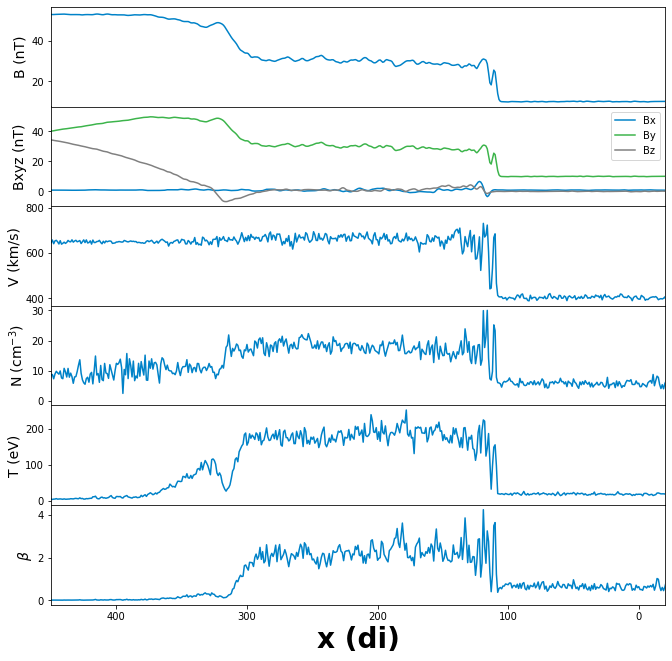

<Figure size 792x792 with 0 Axes>

In [73]:
b_norm = MD.norm((B[0][:, ny0, nz0], B[1][:, ny0, nz0], B[2][:, ny0, nz0]))
v_norm = MD.norm((V[0][:, ny0, nz0], V[1][:, ny0, nz0], V[2][:, ny0, nz0]))

e_th = (3/2)*MD.kB*MD.n*N[:, ny0, nz0]*MD.t*T[:, ny0, nz0]
e_mag = (b*MD.norm(B)[:, ny0, nz0])**2/(2*MD.µ0)
beta = e_th / e_mag

# def cm2inch(value):
#     return value / 2.54
# plt.figure(figsize=(cm2inch(21), cm2inch(29.7)))

flatui = ["#0082c8" , "#3cb44b", "#808080", "#e74c3c", "#34495e", "#2ecc71"]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=flatui)
    
rcParams["figure.figsize"] = [11, 11]
gs = GridSpec(6, 1)
fsize = 14

axe = plt.subplot(gs[0])
plt.plot(x, b_norm)
plt.ylabel('B (nT)', fontsize=fsize)
axe.get_xaxis().set_visible(False)

axe = plt.subplot(gs[1], sharex=axe)
plt.plot(x[:], B[0][:, ny0, nz0], label='Bx')
plt.plot(x[:], B[1][:, ny0, nz0], label='By')
plt.plot(x[:], B[2][:, ny0, nz0], label='Bz')
plt.legend()
plt.ylabel('Bxyz (nT)', fontsize=fsize)
axe.get_xaxis().set_visible(False)

axe = plt.subplot(gs[2], sharex=axe)
plt.plot(x[:], v_norm)
plt.ylabel('V (km/s)', fontsize=fsize)
axe.get_xaxis().set_visible(False)

axe = plt.subplot(gs[3], sharex=axe)
plt.plot(x[:], N[:, ny0, nz0])
plt.ylabel(r'N (cm$^{-3}$)', fontsize=fsize)
axe.get_xaxis().set_visible(False)
         
axe = plt.subplot(gs[4], sharex=axe)
plt.plot(x[:], T[:, ny0, nz0])
plt.ylabel('T (eV)', fontsize=fsize)
axe.get_xaxis().set_visible(False)

axe = plt.subplot(gs[5], sharex=axe)
plt.plot(x[:], beta)
plt.ylabel(r'$\beta$', fontsize=fsize)

plt.xlim([450, -20])
plt.xlabel('x (di)', fontsize=fsize*2, weight='bold')
plt.subplots_adjust(hspace=0)

fileout = "global_view_sheath_"+run_name
plt.savefig(filepath_out + fileout, dpi=150)
print('Figure saved as ', filepath_out + fileout)

plt.figure()

### General view

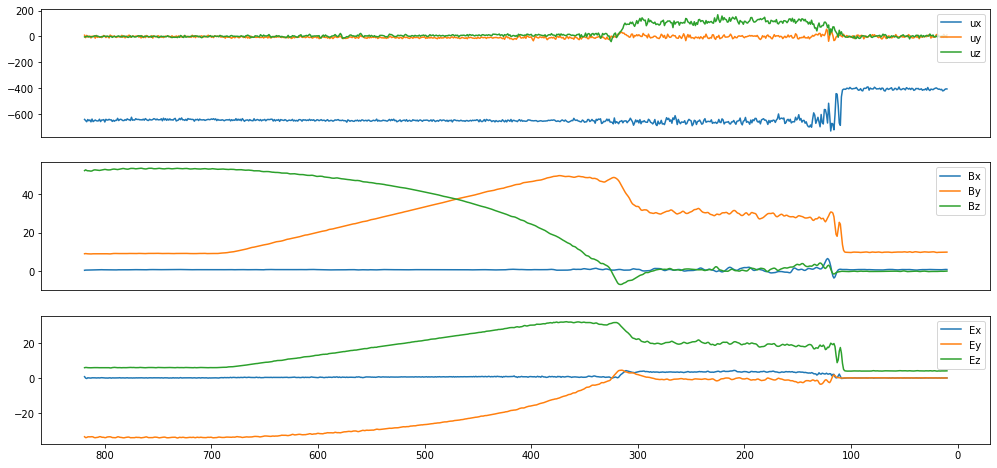

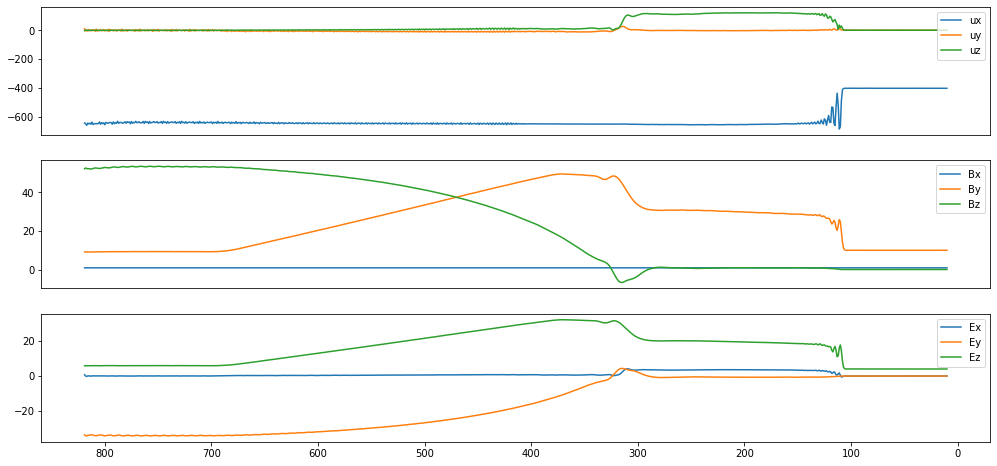

In [11]:
x_slice = slice(np.where(x==10)[0][0], np.where(x==820)[0][0])
y_slice = slice(ny0-1, ny0+1)
z_slice = slice(nz0-1, nz0+1)

y_slice_2 = slice(2, len(y)-2)
z_slice_2 = slice(2, len(z)-2)

slices = (x_slice, y_slice, z_slice)
slices_2 = (x_slice, y_slice_2, z_slice_2)

def smooth(A):
    return np.mean(A[slices_2], axis=(1,2))

rcParams["figure.figsize"] = [17, 8]
gs = GridSpec(3, 1)

axe = plt.subplot(gs[0])
plt.plot(x[x_slice], V[0][x_slice, ny0, nz0], label='ux')
plt.plot(x[x_slice], V[1][x_slice, ny0, nz0], label='uy')
plt.plot(x[x_slice], V[2][x_slice, ny0, nz0], label='uz')
plt.legend(loc = 'upper right')
axe.get_xaxis().set_visible(False)

axe = plt.subplot(gs[1], sharex=axe)
plt.plot(x[x_slice], B[0][x_slice, ny0, nz0], label='Bx')
plt.plot(x[x_slice], B[1][x_slice, ny0, nz0], label='By')
plt.plot(x[x_slice], B[2][x_slice, ny0, nz0], label='Bz')
plt.legend()
axe.get_xaxis().set_visible(False)

axe = plt.subplot(gs[2], sharex=axe)
plt.plot(x[x_slice], E[0][x_slice, ny0, nz0], label='Ex')
plt.plot(x[x_slice], E[1][x_slice, ny0, nz0], label='Ey')
plt.plot(x[x_slice], E[2][x_slice, ny0, nz0], label='Ez')
plt.legend()

plt.gca().invert_xaxis()

plt.figure()

gs = GridSpec(3, 1)

axe = plt.subplot(gs[0])
plt.plot(x[x_slice], smooth(V[0]), label='ux')
plt.plot(x[x_slice], smooth(V[1]), label='uy')
plt.plot(x[x_slice], smooth(V[2]), label='uz')
plt.legend(loc = 'upper right')
axe.get_xaxis().set_visible(False)

axe = plt.subplot(gs[1], sharex=axe)
plt.plot(x[x_slice], smooth(B[0]), label='Bx')
plt.plot(x[x_slice], smooth(B[1]), label='By')
plt.plot(x[x_slice], smooth(B[2]), label='Bz')
plt.legend()
axe.get_xaxis().set_visible(False)

axe = plt.subplot(gs[2], sharex=axe)
plt.plot(x[x_slice], smooth(E[0]), label='Ex')
plt.plot(x[x_slice], smooth(E[1]), label='Ey')
plt.plot(x[x_slice], smooth(E[2]), label='Ez')
plt.legend()

plt.gca().invert_xaxis()


### Why Vz?

In [ ]:
x_slice = slice(10,760)
y_slice = slice(ny0-1, ny0+1)
z_slice = slice(nz0-1, nz0+1)

y_slice_2 = slice(2, len(y)-2)
z_slice_2 = slice(2, len(z)-2)

slices = (x_slice, y_slice, z_slice)
slices_2 = (x_slice, y_slice_2, z_slice_2)

def smooth(A):
    return np.mean(A[slices_2], axis=(1,2))

#### Rankine-Hugoniot

##### Move to the Hoffmann-Teller frame

In [ ]:
x[np.where(x>=106.75)]

In [ ]:
shock_position = 107.25 #Ugly hard code
i_shock_position = np.where(x==shock_position)[0][0]

upstream_slice   = slice(i_shock_position-80,i_shock_position-30)
downstream_slice = slice(i_shock_position+30,i_shock_position+80)

In [ ]:
x_slice = slice(i_shock_position-200,i_shock_position+200)
y_slice = slice(ny0-1, ny0+1)
z_slice = slice(nz0-1, nz0+1)

y_slice_2 = slice(2, len(y)-2)
z_slice_2 = slice(2, len(z)-2)

slices = (x_slice, y_slice, z_slice)
slices_2 = (x_slice, y_slice_2, z_slice_2)

def smooth(A, xslice=x_slice, yslice=y_slice_2, zslice=z_slice_2):
    slices_ = (xslice, yslice, zslice)
    return np.mean(A[slices_], axis=(1,2))

In [ ]:
rcParams["figure.figsize"] = [17, 2]

plt.plot(x[x_slice], Vx[x_slice, ny0, nz0], label="Vx")
plt.plot(x[upstream_slice  ], Vx[upstream_slice, ny0, nz0], color="red")
plt.plot(x[downstream_slice], Vx[downstream_slice, ny0, nz0], color="red")
plt.ylabel('km/s')
plt.legend(loc='lower right')
plt.gca().invert_xaxis()

In [ ]:
rcParams["figure.figsize"] = [17, 2]

plt.plot(x[x_slice], smooth(Vx), label="<Vx>")
plt.plot(x[upstream_slice  ], np.mean(Vx[upstream_slice  , y_slice_2, z_slice_2], axis=(1,2)), color="red")
plt.plot(x[downstream_slice], np.mean(Vx[downstream_slice, y_slice_2, z_slice_2], axis=(1,2)), color="red")
plt.ylabel('km/s')
plt.legend(loc='lower right')
plt.gca().invert_xaxis()

In [ ]:
v_up = np.nanmean(Vx[upstream_slice, y_slice_2, z_slice_2])
print(f"v_upstream = {v_up:0.0f} km/s")

v_down = np.nanmean(Vx[downstream_slice, y_slice_2, z_slice_2])
print(f"v_downstream = {v_down:0.0f} km/s")

n_up = np.nanmean(N[upstream_slice, y_slice_2, z_slice_2])
print(f"n_upstream = {n_up:0.0f} ions/cm^3")

n_down = np.nanmean(N[downstream_slice, y_slice_2, z_slice_2])
print(f"n_downstream = {n_down:0.0f} ions/cm^3")

In [ ]:
V_HF = (n_up*v_up - n_down*v_down)/(n_up - n_down)

print(f'V_Hoffman-Teller = {V_HF:0.0f} km/s')

In [ ]:
Vx_hf = Vx - V_HF

##### Estimate signal frequency in the downstream region

In [ ]:
T_down = np.nanmean(T[downstream_slice, y_slice_2, z_slice_2])
vth_down = np.sqrt(MD.kB*T_down*MD.t/MD.mp)
B_down = np.nanmean(MD.norm(B)[downstream_slice, y_slice_2, z_slice_2])
v_down_hf_frame = v_down - V_HF

print(f"T_down = {T_down*MD.t:.2e} K")
print(f"vth_down = {vth_down/MD.v:.0f} km/s")
print(f"v_down_hf_frame = {v_down_hf_frame:.0f} km/s")
print(f"B_down = {B_down:.0f} nT")

wci_down = MD.qe*B_down*MD.b / MD.mp
print(f"wci_downstream = {wci_down:0.1f} rad/s")

rL_down = vth_down / wci_down
print(f"rL_down = {rL_down*1e-3:0.1f} km")

print("\n")

T_up = np.nanmean(T[upstream_slice, y_slice_2, z_slice_2])
vth_up = np.sqrt(MD.kB*T_up*MD.t/MD.mp)
B_up = np.nanmean(MD.norm(B)[upstream_slice, y_slice_2, z_slice_2])
v_up_hf_frame = v_up - V_HF

print(f"T_up = {T_up*MD.t:.2e} K")
print(f"vth_up = {vth_up/MD.v:.0f} km/s")
print(f"v_up_hf_frame = {v_up_hf_frame:.0f} km/s")
print(f"B_up = {B_up:.0f} nT")

wci_up = MD.qe*B_up*MD.b / MD.mp
print(f"wci_upstream = {wci_up:0.1f} rad/s")

rL_up = vth_up / wci_up
print(f"rL_up = {rL_up*1e-3:0.1f} km")

In [ ]:
T_cyclotron = 2*pi / wci_down
print(f"T_cyclotron = {2*T_cyclotron:0.2f} s")

# dt_half_gyration = pi*rL_down / vth_down
# print(dt_half_gyration)

d_guiding_center = v_down_hf_frame * T_cyclotron

print(f"lambda_c = {d_guiding_center:0.2f} km")

print(f"since cwp = {cwp[0]:0.2f} km, we have:")

print(f"lambda_c_in_di = {d_guiding_center / cwp[0]:0.2f}")

In [ ]:
ne = np.array(N[:])
Te = np.mean(T[50:150, ny0, nz0]) * (ne/6)**(2/3) #eV

In [ ]:
np.mean(T[50:150, ny0, nz0])

In [ ]:
np.mean(Te)

In [ ]:
Pe = (3/2)*MD.kB*np.array(ne*n*Te*MD.t)

In [ ]:
rcParams["figure.figsize"] = [17, 6]
fig,ax = plt.subplots()
ax.plot(x[x_slice], smooth(Pe)*1e9, label="Pe")
plt.legend(loc='upper right')
plt.ylabel('nPa')
ax2=ax.twinx()
ax2.plot(x[x_slice], smooth(By), label='By', color="magenta")
plt.legend(loc='lower right')
plt.ylabel('nT')
plt.xlim([shock_position+30,shock_position-15])

In [ ]:
number_of_wavelengths = 3
distance_between_first_and_last_peak = 128-120
lambda_c_simu = distance_between_first_and_last_peak / number_of_wavelengths

print(f"lambda_c_simu_in_di = {lambda_c_simu:0.2f}")

In [ ]:
# fourier_slice = slice(int(i_shock_position+5/MD.gstep[0]), int(i_shock_position+50/MD.gstep[0]))

# t = x[fourier_slice]

# signal = smooth(N, xslice=fourier_slice) - np.mean(signal)

# # consider zeros to be negative, since we are looking for return to positive
# signal[np.where(signal == 0.0)] = -1e-100

# # find any returns to positive
# return_to_positive = 1 + np.where(2 == np.diff(np.sign(signal)))[0]

# # the periods are the distance between `return to positives`
# periods = np.diff(return_to_positive)

# period = np.mean(periods)*gstep[0]

# print(period)

# plt.plot(t, signal)
# plt.scatter(t[return_to_positive], np.zeros(len(t[return_to_positive])))

In [ ]:
# import numpy as np

# x_data = t
# y_data = signal

# # And plot it
# import matplotlib.pyplot as plt
# plt.figure(figsize=(6, 4))
# plt.scatter(x_data, y_data)

# from scipy import optimize

# def test_func(x, a, b):
#     return a * np.sin(b * x)

# params, params_covariance = optimize.curve_fit(test_func, x_data, y_data,
#                                                p0=[2, 2])

# print(params)

# plt.figure(figsize=(6, 4))
# plt.plot(x_data, y_data, label='Data')
# plt.plot(x_data, test_func(x_data, params[0], params[1]),
#          label='Fitted function')

# plt.legend(loc='best')

# plt.show()

# period = 2*pi / params[1]

# print(period)

##### Mach number

In [ ]:
B_up = np.nanmean(MD.norm(B, slice_=(upstream_slice, y_slice_2, z_slice_2)))
print(f"B_upstream = {B_up:0.0f} nT")

vA_up = B_up*MD.b / sqrt(MD.µ0 * MD.mp * n_up*MD.n)
print(f"upstream Alfvén speed = {vA_up/MD.v:0.0f} km/s")

MA_ips = (abs(V_HF)-abs(v_up)) / (vA_up/MD.v)
print(f"Shock's Mach number = {MA_ips:0.1f}")

##### Rankine Hugoniot

\begin{equation}
\begin{split}
    \text{Absence of magnetic monopoles:} \ \ \ \ & \left[ B_n \right] = 0 \\
    \text{Continuity equation:} \ \ \ \ & \left[ \rho u_n \right] = 0 \\
    \text{Maxwell-Faraday:} \ \ \ \ & \left[ u_n B_{t1} - u_{t1} B_n \right] = 0 \ \ \ \& \ \ \ \left[ u_n B_{t2} - u_{t2} B_n \right] = 0 \\
    \text{Equation of motion:} \ \ \ \ & \left[ \frac{1}{2}\rho u_n \vec{u} + (P_\text{th} + \frac{B^2}{2 \mu_0}) \vec{e}_n - \frac{B_n \vec{B}}{\mu_0} \right] = 0 \\
\end{split}
\end{equation}

In [ ]:
n_plots = 5

rcParams["figure.figsize"] = [17, n_plots*3]
matplotlib.rcParams.update({'font.size': 15})

gs = GridSpec(n_plots, 1)

data = smooth(Bx)
axe = plt.subplot(gs[0])
plt.plot(x[x_slice], np.ones(len(x[x_slice]))*np.nanmean(Bx[upstream_slice, y_slice_2, z_slice_2]), color='red', linestyle="--")

plt.plot(x[x_slice], smooth(Bx), label=r'$B_x$')
plt.legend(loc='lower right')
plt.ylabel("nT")
axe.get_xaxis().set_visible(False)
axe.set_ylim([min(0, min(data)*1.2), max(data*1.2)])

data = smooth(N*Vx_hf)
axe = plt.subplot(gs[1], sharex=axe)
plt.plot(x[x_slice], np.ones(len(x[x_slice]))*np.nanmean((N*Vx_hf)[upstream_slice, y_slice_2, z_slice_2]), color='red', linestyle="--")
plt.plot(x[x_slice], data, label=r'$n u_x$')
plt.legend(loc='lower right')
plt.ylabel(r'cm$^{-3} \cdot$ km/s')
axe.get_xaxis().set_visible(False)
axe.set_ylim([min(0, min(data)*1.2), max(data*1.2)])

data = smooth(Vx_hf*By - Vy*Bx)
axe = plt.subplot(gs[2], sharex=axe)
plt.plot(x[x_slice], np.ones(len(x[x_slice]))*np.nanmean((Vx_hf*By - Vy*Bx)[upstream_slice, y_slice_2, z_slice_2]), color='red', linestyle="--")
plt.plot(x[x_slice], data, label=r'$u_x B_{y} - u_{y} B_x$')
plt.legend(loc='lower right')
plt.ylabel(r"nT $\cdot$ km/s")
axe.get_xaxis().set_visible(False)
axe.set_ylim([min(0, min(data)*1.2), max(data*1.2)])

data = smooth(Vx_hf*Bz - Vz*Bx)
axe = plt.subplot(gs[3], sharex=axe)
plt.plot(x[x_slice], np.ones(len(x[x_slice]))*np.nanmean((Vx_hf*Bz - Vz*Bx)[upstream_slice, y_slice_2, z_slice_2]), color='red', linestyle="--")
plt.plot(x[x_slice], data, label=r'$u_x B_{z} - u_{z} B_x$')
plt.legend(loc='upper right')
plt.ylabel(r"nT $\cdot$ km/s")
axe.set_ylim([min(0, min(data)*1.2), max(data*1.2)])


# rcParams["figure.figsize"] = [17, 4]
# plt.figure()
# axe = plt.subplot(sharex=axe)
# plt.plot(x[x_slice], smooth(  (1/2)*MD.mp*N*n*(v*Vx_hf)**2 \
#                             + MD.kB*N*n*T*MD.t       \
#                             + (MD.norm(B)*b)**2/(2*MD.µ0) - (b*Bx)**2/MD.µ0) \
# , label=r'$ \frac{1}{2}\rho u_n \vec{u} + (P_{th} + \frac{B^2}{2 \mu_0}) \vec{e}_n - \frac{B_n \vec{B}}{\mu_0}$')
# plt.plot(x[x_slice], smooth((1/2)*MD.mp*N*n*(v*Vx_hf)**2), label='Pdyn')
# plt.plot(x[x_slice], smooth(MD.kB*N*n*T*MD.t), label='Pth')
# plt.plot(x[x_slice], smooth((MD.norm(B)*b)**2/(2*MD.µ0) - (b*Bx)**2/MD.µ0), label='Pmag')  # - (b*Bx)**2/MD.µ0
# plt.legend(loc='upper right')
# axe.set_ylim(bottom=0)

plt.gca().invert_xaxis()


#### Ohm's law

$$ E = - v_i \times B + \frac{j \times B}{n_e e} - \frac{\nabla \cdot P_e}{n_e e}$$

##### Preliminary computations & definitions

In [ ]:
i = 0

In [ ]:
advection = -b*v*MD.cross_product(V, B, slice_=slices)[i]
advection = np.mean(advection, axis=(1,2))

Hall = j*b/n*MD.cross_product(J, B, slice_=slices)[i] * (1/(qe*N[slices]))
Hall = np.mean(Hall, axis=(1,2))

vector_Pe = np.sqrt(1/3)*np.array([Pe, Pe, Pe])

pressure = - (MD.gradient(vector_Pe)/(cwp*1e3) / (qe*N*n)) [i][x_slice, ny0, nz0]

Ohm = advection + Hall + pressure 

In [ ]:
advection_2 = -b*v*MD.cross_product(V, B, slice_=slices_2)[i]
advection_2 = np.mean(advection_2, axis=(1,2))

Hall_2 = j*b/n*MD.cross_product(J, B, slice_=slices_2)[i] * (1/(qe*N[slices_2]))
Hall_2 = np.mean(Hall_2, axis=(1,2))

vector_Pe = np.sqrt(1/3)*np.array([Pe, Pe, Pe])

pressure_2 = - (MD.gradient(vector_Pe)/(cwp*1e3) / (qe*N*n)) [i][slices_2]
pressure_2 = np.mean(pressure_2, axis=(1,2))

Ohm_2 = advection_2 + Hall_2 + pressure_2

##### Plots

In [ ]:
rcParams["figure.figsize"] = [17, 18]

gs = GridSpec(7, 1)

axe = plt.subplot(gs[0])
plt.plot(x[x_slice], Ex[x_slice, ny0, nz0], label='electric field')
plt.legend()
axe.get_xaxis().set_visible(False)

axe = plt.subplot(gs[1], sharex=axe)
plt.plot(x[x_slice], e*advection, label='advection')
plt.legend()
axe.get_xaxis().set_visible(False)

axe = plt.subplot(gs[2], sharex=axe)
plt.plot(x[x_slice], By[x_slice, ny0, nz0], label='By')
plt.legend()
axe.get_xaxis().set_visible(False)

axe = plt.subplot(gs[3], sharex=axe)
plt.plot(x[x_slice], np.mean(MD.Jx(B, slices), axis=(1,2)), label='Jx')
plt.plot(x[x_slice], np.mean(MD.Jy(B, slices), axis=(1,2)), label='Jy')
plt.plot(x[x_slice], np.mean(MD.Jz(B, slices), axis=(1,2)), label='Jz')
plt.legend()
axe.get_xaxis().set_visible(False)

axe = plt.subplot(gs[4], sharex=axe)
plt.plot(x[x_slice], e*Hall, label='Hall')
plt.legend()
axe.get_xaxis().set_visible(False)

axe = plt.subplot(gs[5], sharex=axe)
plt.plot(x[x_slice], Pe[x_slice, ny0, nz0], label='Pe')
plt.legend()
axe.get_xaxis().set_visible(False)

axe = plt.subplot(gs[6], sharex=axe)
plt.plot(x[x_slice], e*pressure, label='pressure term')
plt.legend()

plt.gca().invert_xaxis()

rcParams["figure.figsize"] = [17, 6]
plt.figure()
plt.plot(x[x_slice], E[i][x_slice, ny0, nz0], label='electric field')
plt.plot(x[x_slice], e*Ohm, label="Ohm's law", color="black")
plt.plot(x[x_slice], e*advection, label='advection')
plt.plot(x[x_slice], e*Hall, label='Hall')
plt.plot(x[x_slice], e*pressure, label='pressure term')
plt.legend(loc='upper right')

plt.xlim([shock_position+30,shock_position-15])

In [ ]:
rcParams["figure.figsize"] = [17, 6]
fig,ax = plt.subplots()
ax.plot(x[x_slice], np.mean(E[i][slices_2], axis=(1,2)), label='electric field', color='black', linewidth=3)
ax.plot(x[x_slice], e*Ohm_2, label='Ohm_2', linewidth=3)
ax.plot(x[x_slice], e*advection_2, label='advection_2')
ax.plot(x[x_slice], e*Hall_2, label='Hall_2')
ax.plot(x[x_slice], e*pressure_2, label='pressure_2')
plt.legend(loc='upper right')
# ax2=ax.twinx()
# ax2.plot(x[x_slice], smooth(N), label='density', color="red")
# plt.legend(loc='lower right')
# plt.ylabel(r'cm$^{-3}$')
# ax2.set_ylim([-5*max(smooth(N)), 1.2*max(smooth(N))])
plt.xlim([shock_position+30,shock_position-15])

#### Understanding

In [ ]:
rcParams["figure.figsize"] = [17, 6]
fig,ax = plt.subplots()
ax.plot(x[x_slice], smooth(Pe)*1e9, label="Pe")
plt.legend(loc='upper right')
plt.ylabel('nPa')
ax2=ax.twinx()
ax2.plot(x[x_slice], smooth(N), label='N', color="green")
plt.legend(loc='lower right')
plt.ylabel(r'cm$^{-3}$')
plt.xlim([shock_position+30,shock_position-15])

In [ ]:
rcParams["figure.figsize"] = [17, 6]
fig,ax = plt.subplots()
ax.plot(x[x_slice], smooth(Pe)*1e9, label="Pe")
plt.legend(loc='upper right')
plt.ylabel('nPa')
ax2=ax.twinx()
ax2.plot(x[x_slice], smooth(np.gradient(Pe)[i]), label='grad(Pe).ex', color="orange")
plt.legend(loc='lower right')
plt.xlim([shock_position+30,shock_position-15])

In [ ]:
rcParams["figure.figsize"] = [17, 6]
fig,ax = plt.subplots()
ax.plot(x[x_slice], smooth(Pe)*1e9, label="Pe")
plt.legend(loc='upper right')
plt.ylabel('nPa')
ax2=ax.twinx()
ax2.plot(x[x_slice], pressure_2*e, label=r'$-\nabla_x \cdot Pe / (e n)$', color="orange")
plt.legend(loc='lower right')
plt.ylabel('mv/m')
plt.xlim([shock_position+30,shock_position-15])

In [ ]:
rcParams["figure.figsize"] = [17, 6]
fig,ax = plt.subplots()
ax.plot(x[x_slice], smooth(Ex), label="Ex")
plt.ylabel('mv/m')
plt.legend(loc='upper right')
ax2=ax.twinx()
ax2.plot(x[x_slice], smooth(N), label='N', color="green")
plt.legend(loc='lower right')
plt.ylabel(r'cm$^{-3}$')
plt.xlim([shock_position+30,shock_position-15])

In [ ]:
rcParams["figure.figsize"] = [17, 6]
fig,ax = plt.subplots()
ax.plot(x[x_slice], smooth(Ex), label="Ex")
plt.ylabel('mv/m')
plt.legend(loc='upper right')
ax2=ax.twinx()
ax2.plot(x[x_slice], pressure_2*e, label=r'$-\nabla_x \cdot Pe / (e n)$', color="orange")
plt.legend(loc='lower right')
plt.ylabel('mv/m')
plt.xlim([shock_position+30,shock_position-15])

In [ ]:
rcParams["figure.figsize"] = [17, 6]
fig,ax = plt.subplots()
ax.plot(x[x_slice], smooth(Ex), label="Ex")
plt.ylabel('mv/m')
plt.legend(loc='upper right')
ax2=ax.twinx()
ax2.plot(x[x_slice], smooth(Vz), label='Vz', color="red")
plt.legend(loc='lower right')
plt.ylabel('km/s')
plt.xlim([shock_position+30,shock_position-15])

In [ ]:
rcParams["figure.figsize"] = [17, 6]
fig,ax = plt.subplots()
ax.plot(x[x_slice], smooth(N), label='N', color="green")
plt.ylabel(r'cm$^{-3}$')
plt.legend(loc='upper right')
ax2=ax.twinx()
ax2.plot(x[x_slice], smooth(Vz), label='Vz', color="red")
plt.legend(loc='lower right')
plt.ylabel('km/s')
plt.xlim([shock_position+30,shock_position-15])

In [ ]:
wci_down = MD.qe*B_down*MD.b / MD.mp
print(f"wci_downstream={wci_down}")

print(f"lambda={(2*pi/wci_down)*(v_down - V_HF) / cwp[0]}")

#### p3 files

##### Download data

In [ ]:
posx = []
posy = []
posz = []

velx = []
vely = []
velz = []

i = 0

filepath_p3 = filepath + '/p3_files/'

for p3_file in listdir(filepath_p3):
    
    if not(".nc" in p3_file):
        continue
    
    i+=1
        
    print("Reading file", i, "/", len(listdir(filepath_p3)), end="\r")
#    print("Reading ", p3_file, " ...", end="\r")

    p3_data = nc.Dataset(filepath_p3 + p3_file,'r')
    
    posx = posx + list(np.array(p3_data.variables['particule_x']))
    posy = posy + list(np.array(p3_data.variables['particule_y']))
    posz = posz + list(np.array(p3_data.variables['particule_z']))

    velx = velx + list(-np.array(p3_data.variables['particule_vx']))
    vely = vely + list(-np.array(p3_data.variables['particule_vy']))
    velz = velz + list(np.array(p3_data.variables['particule_vz']))


In [ ]:
nx = len(x)
ny = len(y)
nz = len(z)
dx = MD.gstep[0]
dy = MD.gstep[1]
dz = MD.gstep[2]
px = (nx - 100)*dx
py = ny/2 * dy
pz = nz/2 * dz

def pos_gse(pos_simu, planet, sgn):
    return sgn*(np.array(pos_simu) - planet*np.ones(len(pos_simu)))

# Move from x_simu to x_gse
rposx = pos_gse(posx, px, -1)
rposy = pos_gse(posy, py, -1)
rposz = pos_gse(posz, pz,  1)

#### Crop dataset

In [ ]:
xlims = (shock_position-10.5, shock_position+29.5)
ylims = (-10, 10)
zlims = (-10, 10)
print(xlims)

In [ ]:
def inregion(pos_part):
    x_part, y_part, z_part = pos_part
    return (    (xlims[0] < x_part < xlims[1]) 
            and (ylims[0] < y_part < ylims[1]) 
            and (zlims[0] < z_part < zlims[1]) )

In [ ]:
x_parts = [rposx[i] for i in range(0, len(rposx))
      if inregion((rposx[i], rposy[i], rposz[i]))]
y_parts = [rposy[i] for i in range(0, len(rposx))
      if inregion((rposx[i], rposy[i], rposz[i]))]
z_parts = [rposz[i] for i in range(0, len(rposx))
      if inregion((rposx[i], rposy[i], rposz[i]))]

vA = 89.371 #Ugly hard code
vx_parts = [velx[i]*vA for i in range(0, len(rposx))
      if inregion((rposx[i], rposy[i], rposz[i]))]
vy_parts = [vely[i]*vA for i in range(0, len(rposx))
      if inregion((rposx[i], rposy[i], rposz[i]))]
vz_parts = [velz[i]*vA for i in range(0, len(rposx))
      if inregion((rposx[i], rposy[i], rposz[i]))]

In [ ]:
plt.scatter(vx_parts, vz_parts, s = 0.00005)
# plt.xlim(xlims[1], xlims[0])